<a href="https://colab.research.google.com/github/tom-dupuis/Vessel_logistics/blob/main/Windconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Class creation : vessels, WFs, ports**

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt


class Vessels:
  def __init__(self, vessel_type, name, position):
    self.status = "available"
    self.vessel_type = vessel_type
    self.name = name
    self.position = position
    self.speed = 10  #km/h


class WindFarm:
    def __init__(self, name, position, n_turb):
        self.status = "available"
        self.name = name
        self.position = position
        self.n_turb = n_turb
        self.start_date = None
        self.turbines_installed = 0
        self.foundations_installed = 0


#**Fonctions**



## Distance between WFs

In [ ]:
def distance(position1, position2):
    # Calculate Euclidean distance between two positions
    return math.sqrt((position1[0] - position2[0]) ** 2 + (position1[1] - position2[1]) ** 2)

## Month

In [ ]:
def get_month(time):
    months = [
        "January", "February", "March", "April",
        "May", "June", "July", "August",
        "September", "October", "November", "December"
    ]
    
    days_per_month = [
        31, 28, 31, 30,
        31, 30, 31, 31,
        30, 31, 30, 31
    ]
    
    total_days = sum(days_per_month)
    current_day = time % total_days
    
    month_index = 0
    while current_day >= days_per_month[month_index]:
        current_day -= days_per_month[month_index]
        month_index += 1
    
    return months[month_index]


## Construction time

In [ ]:
def calculate_construction_time(month):
    construction_time = {
        "January": {"turbine_construction_time": 7, "foundation_construction_time": 4},
        "February": {"turbine_construction_time": 6.5, "foundation_construction_time": 3},
        "March": {"turbine_construction_time": 6, "foundation_construction_time": 3},
        "April": {"turbine_construction_time": 5, "foundation_construction_time": 2.5},
        "May": {"turbine_construction_time": 4.5, "foundation_construction_time": 2},
        "June": {"turbine_construction_time": 4, "foundation_construction_time": 2.5},
        "July": {"turbine_construction_time": 6.6, "foundation_construction_time": 3},
        "August": {"turbine_construction_time": 7, "foundation_construction_time": 4},
        "September": {"turbine_construction_time": 8, "foundation_construction_time": 4.5},
        "October": {"turbine_construction_time": 8.5, "foundation_construction_time": 5},
        "November": {"turbine_construction_time": 8.5, "foundation_construction_time": 5},
        "December": {"turbine_construction_time": 8, "foundation_construction_time": 4.5}
    }

    return construction_time[month]

##Allocation

allocation that assigns a vessel (no role distinction for vessels) to a WF for the contruction. the allocation comes as an input to be updated. 

when allocated, WF and vessel become "under construction" and "not available" for the duration of the project.



In [ ]:
def allocation_last(vessels, wind_farms, allocation):
    for wind_farm in wind_farms:
        if wind_farm.status == "available":
            vessel_allocated = False
            for vessel in vessels:
                if vessel.status == "available":
                    allocation.append({
                        "wind_farm": wind_farm,
                        "vessel": vessel,
                        "foundation_duration": 0,
                        "turbine_duration": 0,
                        "project_turbines_installed": 0
                    })
                    vessel.status = "not available"
                    wind_farm.status = "under construction"
                    wind_farm.start_date = time
                    vessel_allocated = True
                    break

    return allocation

### This function does an allocation for the installation of the foundations with an HLV and an allocation for 
### the installation of the turbines with an JUV.

def allocation_vessels(vessels, wind_farms, allocation):
    for wind_farm in wind_farms:

        hlv_vessel = allocate_vessel(vessels, wind_farm, "HLV")
        juv_vessel = allocate_vessel(vessels, wind_farm, "JUV")

        if wind_farm.status == "available" and hlv_vessel is not None:
            if juv_vessel is not None:
              allocation.append({
                "wind_farm": wind_farm,
                "hlv_vessel": hlv_vessel,
                "juv_vessel": juv_vessel,
                "foundation_duration": 0,
                "turbine_duration": 0,
                "project_turbines_installed": 0
              })
              hlv_vessel.status = "not available"
              juv_vessel.status = "not available"
              wind_farm.status = "under construction"
              wind_farm.start_date = time
              break

            elif juv_vessel is None:
              allocation.append({
                "wind_farm": wind_farm,
                "hlv_vessel": hlv_vessel,
                "juv_vessel": None,
                "foundation_duration": 0,
                "turbine_duration": 0,
                "project_turbines_installed": 0
              })
              hlv_vessel.status = "not available"
              wind_farm.status = "under construction"
              wind_farm.start_date = time
              break

    for project in allocation:
        if juv_vessel is not None and project["juv_vessel"] is None:
              project["juv_vessel"] = juv_vessel
              juv_vessel.status = "not available"
              break

    return allocation


def allocate_vessel(vessels, wind_farm, vessel_type):
    for vessel in vessels:
        if vessel.status == "available" and vessel.vessel_type == vessel_type:
            return vessel
    return None


##Construction


this construction function takes a project and the total number of turbines installed worldwide as inpute to update them. 

Here the project is constructed by installing all foundations first and then installing the turbines. When all turbines are installed, the project is deleted from the allocation variable and the vessel becomes available again.

In [ ]:
def construction(project, tot_turbine_installed):
    
    project_duration = time - project["wind_farm"].start_date

    if project_duration >= mobilization_duration:  # The construction cannot start before the mobilization ended.
        
        if project["project_turbines_installed"] >= project["wind_farm"].n_turb:
            project["wind_farm"].status = "complete"
            project["vessel"].status = "available"
            allocation_results.remove(project)

        else:
            if project["wind_farm"].foundations_installed >= project["wind_farm"].n_turb:
                
                if project["turbine_duration"] >= turbine_construction_time:
                    project["project_turbines_installed"] += 1
                    tot_turbine_installed += 1
                    project["turbine_duration"] = 0
                else:
                    project["turbine_duration"] += 1

            elif project["foundation_duration"] >= foundation_construction_time:
                
                project["wind_farm"].foundations_installed += 1
                project["foundation_duration"] = 0

            else:
                
                project["foundation_duration"] += 1
                
    return project, tot_turbine_installed


def construction_2(project, tot_turbine_installed, turbine_construction_time, foundation_construction_time):

    project_duration = time - project["wind_farm"].start_date

    if project_duration >= mobilization_duration:  # The construction cannot start before the mobilization ended.

        if project["project_turbines_installed"] >= project["wind_farm"].n_turb:
            project["wind_farm"].status = "complete"
            project["vessel"].status = "available"
            allocation_results.remove(project)

        else:
            if project["wind_farm"].foundations_installed >= project["wind_farm"].n_turb:

                if project["turbine_duration"] >= turbine_construction_time:
                    project["project_turbines_installed"] += 1
                    tot_turbine_installed += 1
                    project["turbine_duration"] = 0
                else:
                    project["turbine_duration"] += 1

            elif project["foundation_duration"] >= foundation_construction_time:

                project["wind_farm"].foundations_installed += 1
                project["foundation_duration"] = 0

            else:

                project["foundation_duration"] += 1

    return project, tot_turbine_installed


def construction_3(project, allocation, total_turbines_installed, total_foundations_installed, turbine_construction_time, foundation_construction_time):

    project_duration = time - project["wind_farm"].start_date

    if project_duration >= mobilization_duration:  # The construction cannot start before the mobilization ended.

        if project["project_turbines_installed"] >= project["wind_farm"].n_turb:
            project["wind_farm"].status = "complete"
            project["juv_vessel"].status = "available"
            allocation.remove(project)

        else:
            if (project["wind_farm"].foundations_installed >= project["wind_farm"].n_turb) and (project["juv_vessel"] is not None):
                if project["hlv_vessel"] is not None:
                  project["hlv_vessel"].status = "available"
                  project["hlv_vessel"] = None

                if project["turbine_duration"] >= turbine_construction_time:
                    project["project_turbines_installed"] += 1
                    total_turbines_installed += 1
                    project["turbine_duration"] = 0
                else:
                    project["turbine_duration"] += 1

            elif project["foundation_duration"] >= foundation_construction_time:
                project["wind_farm"].foundations_installed += 1
                total_foundations_installed += 1
                project["foundation_duration"] = 0

            else:
                project["foundation_duration"] += 1

    return project, total_turbines_installed, total_foundations_installed, allocation

def simulate_construction(project, total_turbines_installed, total_foundations_installed):
    project_duration = time - project["wind_farm"].start_date

    if project_duration >= mobilization_duration:
        if project["project_turbines_installed"] >= project["wind_farm"].n_turbines:
            project["wind_farm"].status = "complete"
            project["vessel"].status = "available"
            allocation_results.remove(project)
        else:
            if project["wind_farm"].foundations_installed >= project["wind_farm"].n_turbines:
                if project["turbine_duration"] >= turbine_construction_time:
                    project["project_turbines_installed"] += 1
                    total_turbines_installed += 1
                    project["turbine_duration"] = 0
                else:
                    project["turbine_duration"] += 1
            elif project["foundation_duration"] >= foundation_construction_time:
                project["wind_farm"].foundations_installed += 1
                total_foundations_installed += 1
                project["foundation_duration"] = 0
            else:
                project["foundation_duration"] += 1

    return project, total_turbines_installed, total_foundations_installed


## Graphs

In [ ]:
def graphs(time_values, tot_turbine_installed_values, wind_farm_data):
    # Plotting the total number of turbines installed over time
    plt.figure(figsize=(5, 3))
    plt.plot(time_values, tot_turbine_installed_values)
    plt.xlabel("Time (days)")
    plt.ylabel("Total Turbines Installed")
    plt.title("Total Turbines Installed Over Time")
    plt.grid(True)
    plt.show()


    # Plotting the evolution of the number of turbines installed for each wind farm over time
    plt.figure(figsize=(5, 3))

    for wind_farm, data in wind_farm_data.items():
        plt.plot(data["time_values"], data["turbine_installed_values"], label=wind_farm.name)

    plt.xlabel("Time (days)")
    plt.ylabel("Turbines Installed")
    plt.title("Turbines Installed Over Time")
    plt.legend()
    plt.grid(True)
    plt.xlim(0, modelisation_duration)
    plt.show()

## The following function also plots the installation of foundations. 

def plot_graphs(time_values, turbine_installed_values, foundation_installed_values, wind_farm_data):
    # Plotting the total number of turbines installed over time
    plt.figure(figsize=(5, 3))
    plt.plot(time_values, turbine_installed_values)
    plt.xlabel("Time (days)")
    plt.ylabel("Total Turbines Installed")
    plt.title("Total Turbines Installed Over Time")
    plt.grid(True)
    plt.show()

    # Plotting the total number of foundations installed over time
    plt.figure(figsize=(5, 3))
    plt.plot(time_values, foundation_installed_values)
    plt.xlabel("Time (days)")
    plt.ylabel("Total Foundations Installed")
    plt.title("Total Foundations Installed Over Time")
    plt.grid(True)
    plt.show()

    # Plotting the evolution of the number of turbines installed for each wind farm over time
    plt.figure(figsize=(5, 3))
    for wind_farm, data in wind_farm_data.items():
        plt.plot(data["time_values"], data["turbine_installed_values"], label=wind_farm.name)
    plt.xlabel("Time (days)")
    plt.ylabel("Turbines Installed")
    plt.title("Turbines Installed Over Time")
    plt.legend()
    plt.grid(True)
    plt.xlim(0, modelisation_duration)
    plt.show()

    # Plotting the evolution of the number of foundations installed for each wind farm over time
    plt.figure(figsize=(5, 3))
    for wind_farm, data in wind_farm_data.items():
        plt.plot(data["time_values"], data["foundation_installed_values"], label=wind_farm.name)
    plt.xlabel("Time (days)")
    plt.ylabel("Foundations Installed")
    plt.title("Foundations Installed Over Time")
    plt.legend()
    plt.grid(True)
    plt.xlim(0, modelisation_duration)
    plt.show()


# **Modelisation**

## Version 4 

uses allocation_last() and construction(). duration of construction for foundations and turbines is fixed. No distinction between HLV and JUV (vessel type)

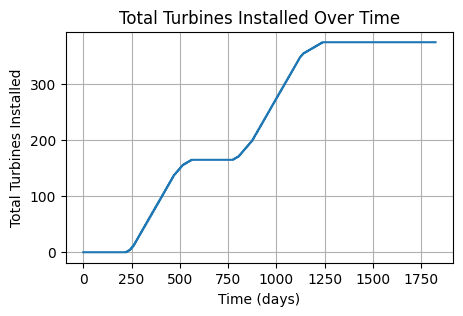

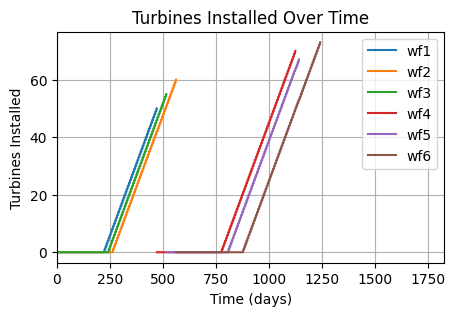

In [ ]:
vessel1 = Vessels(name = "v1", vessel_type = "HLV", position=(0, 0))
vessel2 = Vessels(name = "v2", vessel_type = "HLV", position=(10, 10))
vessel3 = Vessels(name = "v3", vessel_type = "JUV", position=(10, 15))
vessel4 = Vessels(name = "v4", vessel_type = "JUV", position=(10, 20))
vessel5 = Vessels(name = "v5", vessel_type = "JUV", position=(30, 80))

vessels = [vessel1, vessel2, vessel3]

wind_farm1 = WindFarm(name="wf1", position=(5, 5), n_turb=50)
wind_farm2 = WindFarm(name="wf2", position=(20, 200), n_turb=60)
wind_farm3 = WindFarm(name="wf3", position=(15, 150), n_turb=55)
wind_farm4 = WindFarm(name="wf4", position=(160, 12), n_turb=70)
wind_farm5 = WindFarm(name="wf5", position=(160, 40), n_turb=67)
wind_farm6 = WindFarm(name="wf6", position=(80, 300), n_turb=73)

wind_farms = [wind_farm1, wind_farm2, wind_farm3, wind_farm4, wind_farm5, wind_farm6]

modelisation_duration = 365*5
foundation_construction_time = 3  # Time required to construct one foundation
turbine_construction_time = 4  # Time required to construct one wind turbine
mobilization_duration = 20    #Time required to move the vessel to the WF, to equip it, change teams etc

time = 0
tot_turbine_installed = 0
allocation_results = []

time_values = []
tot_turbine_installed_values = []

# Create a dictionary to store the turbine installation data for each wind farm
wind_farm_data = {wind_farm: {"time_values": [], "turbine_installed_values": []} for wind_farm in wind_farms}

while time <= modelisation_duration:
    allocation_results = allocation_last(vessels, wind_farms, allocation_results)

    for project in allocation_results:

        project, tot_turbine_installed = construction(project, tot_turbine_installed)

        wind_farm_data[project["wind_farm"]]["time_values"].append(time)
        wind_farm_data[project["wind_farm"]]["turbine_installed_values"].append(project["project_turbines_installed"])

    time_values.append(time)
    tot_turbine_installed_values.append(tot_turbine_installed)

    time += 1

#Plot the turbines installed in total and per WF for each day :
graphs(time_values, tot_turbine_installed_values, wind_farm_data)

## Version 5

Uses allocation_last() and construction_2 : Includes a variation of construction time based on the month. Still no distinction between HLV and JUV for construction.

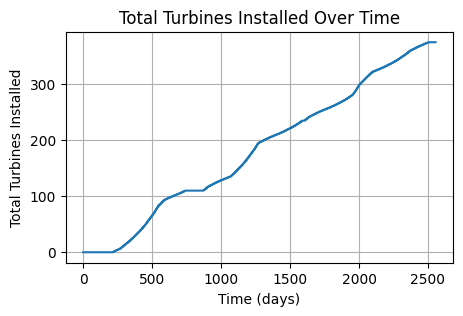

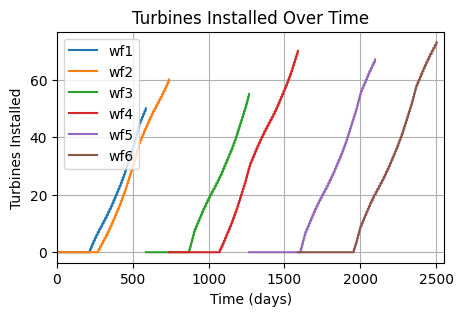

In [ ]:
vessel1 = Vessels(name = "v1", vessel_type = "HLV", position=(0, 0))
vessel2 = Vessels(name = "v2", vessel_type = "HLV", position=(10, 10))
vessel3 = Vessels(name = "v3", vessel_type = "JUV", position=(10, 15))
vessel4 = Vessels(name = "v4", vessel_type = "JUV", position=(10, 20))
vessel5 = Vessels(name = "v5", vessel_type = "JUV", position=(30, 80))

vessels = [vessel1, vessel2]

wind_farm1 = WindFarm(name="wf1", position=(5, 5), n_turb=50)
wind_farm2 = WindFarm(name="wf2", position=(20, 200), n_turb=60)
wind_farm3 = WindFarm(name="wf3", position=(15, 150), n_turb=55)
wind_farm4 = WindFarm(name="wf4", position=(160, 12), n_turb=70)
wind_farm5 = WindFarm(name="wf5", position=(160, 40), n_turb=67)
wind_farm6 = WindFarm(name="wf6", position=(80, 300), n_turb=73)

wind_farms = [wind_farm1, wind_farm2, wind_farm3, wind_farm4, wind_farm5, wind_farm6]

modelisation_duration = 365 * 7 
mobilization_duration = 20   # Time required to move the vessel to the WF, to equip it, change teams, etc.

time = 0
tot_turbine_installed = 0
allocation_results = []

time_values = []
tot_turbine_installed_values = []

# Create a dictionary to store the turbine installation data for each wind farm
wind_farm_data = {wind_farm: {"time_values": [], "turbine_installed_values": []} for wind_farm in wind_farms}

while time <= modelisation_duration:
    allocation_results = allocation_last(vessels, wind_farms, allocation_results)

    for project in allocation_results:
        month = get_month(time)
        construction_times = calculate_construction_time(month)
        turbine_construction_time = construction_times["turbine_construction_time"] 
        foundation_construction_time = construction_times["foundation_construction_time"] 

        project, tot_turbine_installed = construction_2(
            project,
            tot_turbine_installed,
            turbine_construction_time,
            foundation_construction_time
        )

        wind_farm_data[project["wind_farm"]]["time_values"].append(time)
        wind_farm_data[project["wind_farm"]]["turbine_installed_values"].append(project["project_turbines_installed"])

    time_values.append(time)
    tot_turbine_installed_values.append(tot_turbine_installed)

    time += 1

#Plot the turbines installed in total and per WF for each day :
graphs(time_values, tot_turbine_installed_values, wind_farm_data)

ideas : add time to move from one pt to another, add start construction_foundation_time and construction_turbine_time instead of project start date only. 

Find a way to model the capacity

## Version 6

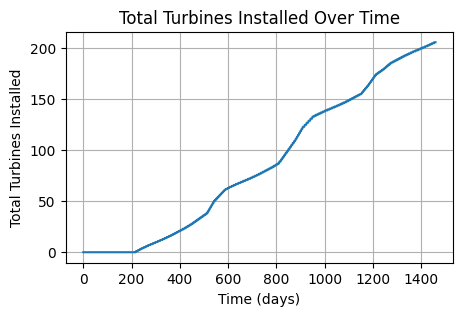

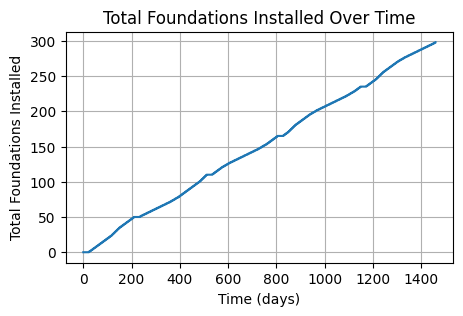

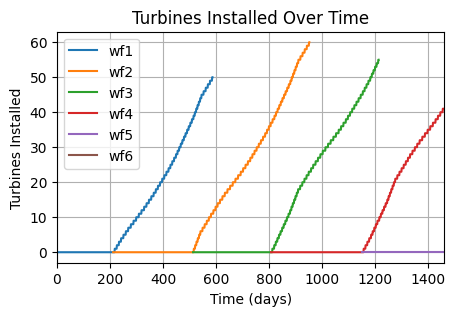

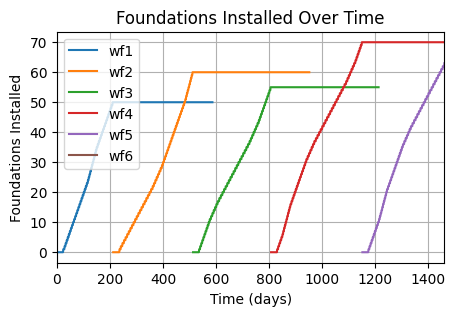

In [ ]:
vessel1 = Vessels(name = "v1", vessel_type = "HLV", position=(0, 0))
vessel2 = Vessels(name = "v2", vessel_type = "HLV", position=(10, 10))
vessel3 = Vessels(name = "v3", vessel_type = "JUV", position=(10, 15))
vessel4 = Vessels(name = "v4", vessel_type = "JUV", position=(10, 20))
vessel5 = Vessels(name = "v5", vessel_type = "JUV", position=(30, 80))

vessels = [vessel1, vessel3, vessel4, vessel5]

wind_farm1 = WindFarm(name="wf1", position=(5, 5), n_turb=50)
wind_farm2 = WindFarm(name="wf2", position=(20, 200), n_turb=60)
wind_farm3 = WindFarm(name="wf3", position=(15, 150), n_turb=55)
wind_farm4 = WindFarm(name="wf4", position=(160, 12), n_turb=70)
wind_farm5 = WindFarm(name="wf5", position=(160, 40), n_turb=67)
wind_farm6 = WindFarm(name="wf6", position=(80, 300), n_turb=73)

wind_farms = [wind_farm1, wind_farm2, wind_farm3, wind_farm4, wind_farm5, wind_farm6]


modelisation_duration = 365 * 4
mobilization_duration = 20   # Time required to move the vessel to the WF, to equip it, change teams, etc.

time = 0
total_turbines_installed = 0
total_foundations_installed = 0
allocation_results = []

time_values = []
turbine_installed_values = []
foundation_installed_values = []

# Create a dictionary to store the turbine and foundation installation data for each wind farm
wind_farm_data = {wind_farm: {"time_values": [], "turbine_installed_values": [], "foundation_installed_values": []} for wind_farm in wind_farms}

while time <= modelisation_duration:
    allocation_results = allocation_vessels(vessels, wind_farms, allocation_results)

    for project in allocation_results:
        month = get_month(time)
        construction_times = calculate_construction_time(month)
        turbine_construction_time = construction_times["turbine_construction_time"] 
        foundation_construction_time = construction_times["foundation_construction_time"] 

        project, total_turbines_installed, total_foundations_installed, allocation_results = construction_3(
            project,
            allocation_results,
            total_turbines_installed,
            total_foundations_installed,
            turbine_construction_time,
            foundation_construction_time
        )

        wind_farm_data[project["wind_farm"]]["time_values"].append(time)
        wind_farm_data[project["wind_farm"]]["turbine_installed_values"].append(project["project_turbines_installed"])
        wind_farm_data[project["wind_farm"]]["foundation_installed_values"].append(project["wind_farm"].foundations_installed)

    time_values.append(time)
    turbine_installed_values.append(total_turbines_installed)
    foundation_installed_values.append(total_foundations_installed)

    time += 1

#Plot the turbines installed in total and per WF for each day :

plot_graphs(time_values, turbine_installed_values, foundation_installed_values, wind_farm_data)



# **Example for CHAT GPT in case of errors**

Modified version of chatgpt with foundation construction and turbine construction

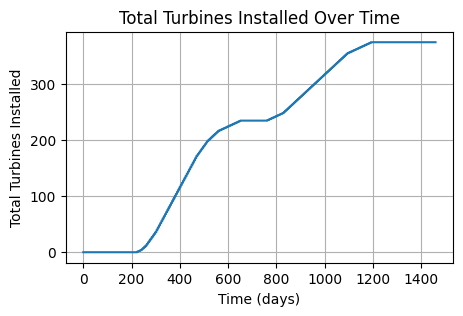

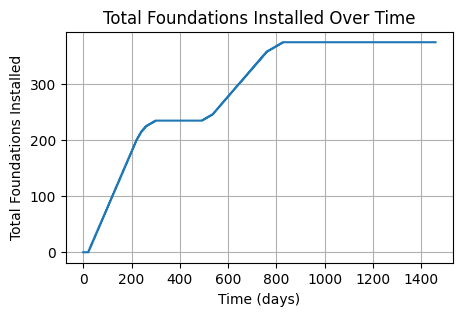

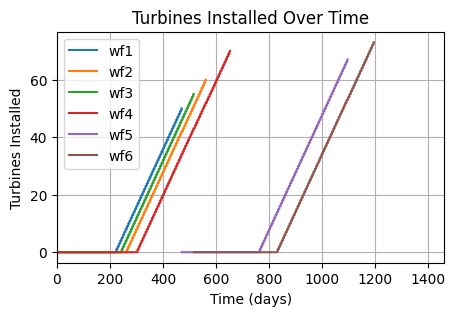

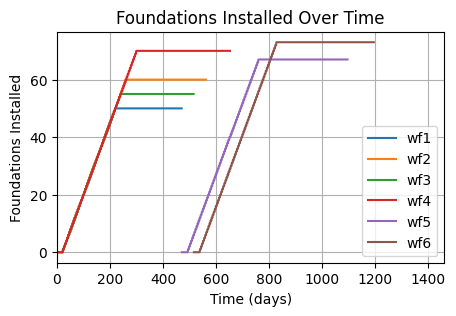

Execution time: 1.064436912536621 seconds


In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import time as t

start_time = t.time()

class Vessel:
    def __init__(self, name, vessel_type, position):
        self.status = "available"
        self.name = name
        self.vessel_type = vessel_type
        self.position = position
        self.speed = 10  # km/h

class WindFarm:
    def __init__(self, name, position, n_turb):
        self.status = "available"
        self.name = name
        self.position = position
        self.n_turb = n_turb
        self.start_date = None
        self.turbines_installed = 0
        self.foundations_installed = 0

def allocate_vessels(vessels, wind_farms, allocation):
    for wind_farm in wind_farms:
        if wind_farm.status == "available":
            for vessel in vessels:
                if vessel.status == "available":
                    allocation.append({
                        "wind_farm": wind_farm,
                        "vessel": vessel,
                        "foundation_duration": 0,
                        "turbine_duration": 0,
                        "project_turbines_installed": 0
                    })
                    vessel.status = "not available"
                    wind_farm.status = "under construction"
                    wind_farm.start_date = time
                    break
    return allocation

def simulate_construction(project, total_turbines_installed, total_foundations_installed):
    project_duration = time - project["wind_farm"].start_date

    if project_duration >= mobilization_duration:
        if project["project_turbines_installed"] >= project["wind_farm"].n_turb:
            project["wind_farm"].status = "complete"
            project["vessel"].status = "available"
            allocation_results.remove(project)
        else:
            if project["wind_farm"].foundations_installed >= project["wind_farm"].n_turb:
                if project["turbine_duration"] >= turbine_construction_time:
                    project["project_turbines_installed"] += 1
                    total_turbines_installed += 1
                    project["turbine_duration"] = 0
                else:
                    project["turbine_duration"] += 1
            elif project["foundation_duration"] >= foundation_construction_time:
                project["wind_farm"].foundations_installed += 1
                total_foundations_installed += 1
                project["foundation_duration"] = 0
            else:
                project["foundation_duration"] += 1

    return project, total_turbines_installed, total_foundations_installed

def plot_graphs(time_values, turbine_installed_values, foundation_installed_values, wind_farm_data):
    # Plotting the total number of turbines installed over time
    plt.figure(figsize=(5, 3))
    plt.plot(time_values, turbine_installed_values)
    plt.xlabel("Time (days)")
    plt.ylabel("Total Turbines Installed")
    plt.title("Total Turbines Installed Over Time")
    plt.grid(True)
    plt.show()

    # Plotting the total number of foundations installed over time
    plt.figure(figsize=(5, 3))
    plt.plot(time_values, foundation_installed_values)
    plt.xlabel("Time (days)")
    plt.ylabel("Total Foundations Installed")
    plt.title("Total Foundations Installed Over Time")
    plt.grid(True)
    plt.show()

    # Plotting the evolution of the number of turbines installed for each wind farm over time
    plt.figure(figsize=(5, 3))
    for wind_farm, data in wind_farm_data.items():
        plt.plot(data["time_values"], data["turbine_installed_values"], label=wind_farm.name)
    plt.xlabel("Time (days)")
    plt.ylabel("Turbines Installed")
    plt.title("Turbines Installed Over Time")
    plt.legend()
    plt.grid(True)
    plt.xlim(0, modelisation_duration)
    plt.show()

    # Plotting the evolution of the number of foundations installed for each wind farm over time
    plt.figure(figsize=(5, 3))
    for wind_farm, data in wind_farm_data.items():
        plt.plot(data["time_values"], data["foundation_installed_values"], label=wind_farm.name)
    plt.xlabel("Time (days)")
    plt.ylabel("Foundations Installed")
    plt.title("Foundations Installed Over Time")
    plt.legend()
    plt.grid(True)
    plt.xlim(0, modelisation_duration)
    plt.show()

# Define the vessels
vessel1 = Vessel(name="v1", vessel_type="HLV", position=(0, 0))
vessel2 = Vessel(name="v2", vessel_type="HLV", position=(10, 10))
vessel3 = Vessel(name="v3", vessel_type="JUV", position=(10, 15))
vessel4 = Vessel(name="v4", vessel_type="JUV", position=(10, 20))
vessel5 = Vessel(name="v5", vessel_type="JUV", position=(30, 80))

vessels = [vessel1, vessel2, vessel3, vessel4]

# Define the wind farms
wind_farm1 = WindFarm(name="wf1", position=(5, 5), n_turb=50)
wind_farm2 = WindFarm(name="wf2", position=(20, 200), n_turb=60)
wind_farm3 = WindFarm(name="wf3", position=(15, 150), n_turb=55)
wind_farm4 = WindFarm(name="wf4", position=(160, 12), n_turb=70)
wind_farm5 = WindFarm(name="wf5", position=(160, 40), n_turb=67)
wind_farm6 = WindFarm(name="wf6", position=(80, 300), n_turb=73)

wind_farms = [wind_farm1, wind_farm2, wind_farm3, wind_farm4, wind_farm5, wind_farm6]

modelisation_duration = 365 * 4
foundation_construction_time = 3  # Time required to construct one foundation
turbine_construction_time = 4  # Time required to construct one wind turbine
mobilization_duration = 20  # Time required to move the vessel to the wind farm, to equip it, change teams, etc.

time = 0
total_turbines_installed = 0
total_foundations_installed = 0
allocation_results = []

time_values = []
turbine_installed_values = []
foundation_installed_values = []

# Create a dictionary to store the turbine and foundation installation data for each wind farm
wind_farm_data = {wind_farm: {"time_values": [], "turbine_installed_values": [], "foundation_installed_values": []} for wind_farm in wind_farms}

while time <= modelisation_duration:
    allocation_results = allocate_vessels(vessels, wind_farms, allocation_results)

    for project in allocation_results:
        project, total_turbines_installed, total_foundations_installed = simulate_construction(project, total_turbines_installed, total_foundations_installed)

        wind_farm_data[project["wind_farm"]]["time_values"].append(time)
        wind_farm_data[project["wind_farm"]]["turbine_installed_values"].append(project["project_turbines_installed"])
        wind_farm_data[project["wind_farm"]]["foundation_installed_values"].append(project["wind_farm"].foundations_installed)

    time_values.append(time)
    turbine_installed_values.append(total_turbines_installed)
    foundation_installed_values.append(total_foundations_installed)

    time += 1

# Plot the turbines and foundations installed over time
plot_graphs(time_values, turbine_installed_values, foundation_installed_values, wind_farm_data)


end_time = t.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")


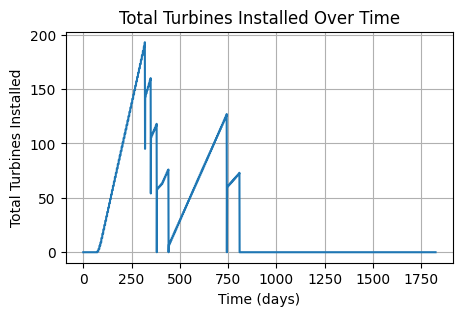

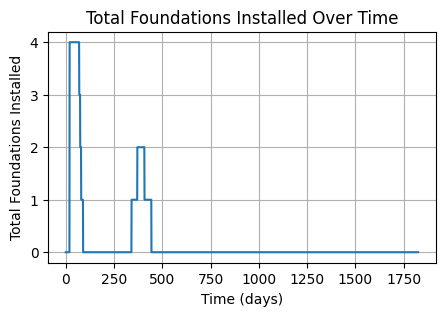

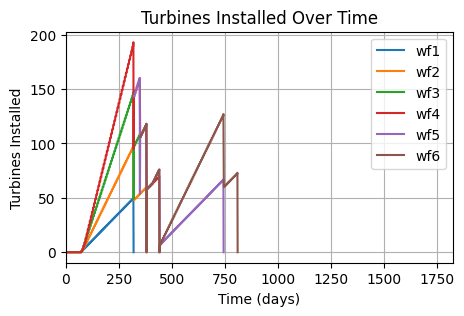

Execution time: 0.6439237594604492 seconds


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time as t

start_time = t.time()


class Vessel:
    def __init__(self, name, vessel_type, position):
        self.status = "available"
        self.vessel_type = vessel_type
        self.name = name
        self.position = position
        self.speed = 10  # km/h


class WindFarm:
    def __init__(self, name, position, n_turbines):
        self.status = "available"
        self.name = name
        self.position = position
        self.n_turbines = n_turbines
        self.start_date = None
        self.turbines_installed = 0
        self.foundations_installed = 0


def allocate_vessels(vessels, wind_farms, allocation_results):
    for wind_farm in wind_farms:
        if wind_farm.status == "available":
            available_vessels = [vessel for vessel in vessels if vessel.status == "available"]
            if len(available_vessels) > 0:
                allocation_results.append({
                    "wind_farm": wind_farm,
                    "vessel": available_vessels[0],
                    "foundation_duration": np.zeros(1),
                    "turbine_duration": np.zeros(1),
                    "project_turbines_installed": np.zeros(1)
                })
                available_vessels[0].status = "not available"
                wind_farm.status = "under construction"
                wind_farm.start_date = time

    return allocation_results


def simulate_construction(project, total_turbines_installed, total_foundations_installed):
    project_duration = time - project["wind_farm"].start_date

    if project_duration >= mobilization_duration:
        if project["project_turbines_installed"] >= project["wind_farm"].n_turbines:
            project["wind_farm"].status = "complete"
            project["vessel"].status = "available"
            allocation_results.remove(project)
        else:
            if project["wind_farm"].foundations_installed >= project["wind_farm"].n_turbines:
                turbines_installed = np.where(
                    project["turbine_duration"] >= turbine_construction_time,
                    project["project_turbines_installed"] + 1,
                    project["project_turbines_installed"]
                )
                total_turbines_installed += turbines_installed
                project["project_turbines_installed"] = turbines_installed
                project["turbine_duration"] = np.where(
                    project["turbine_duration"] >= turbine_construction_time,
                    0,
                    project["turbine_duration"] + 1
                )
            else:
                project["foundation_duration"] = np.where(
                    project["foundation_duration"] >= foundation_construction_time,
                    0,
                    project["foundation_duration"] + 1
                )
                project["wind_farm"].foundations_installed += 1
                total_foundations_installed += 1

    return project, total_turbines_installed, total_foundations_installed


def plot_graphs(time_values, turbine_installed_values, foundation_installed_values, wind_farm_data):
    # Convert the lists to NumPy arrays for efficient operations
    time_values = np.array(time_values)
    turbine_installed_values = np.array(turbine_installed_values)
    foundation_installed_values = np.array(foundation_installed_values)

    # Plotting the total number of turbines installed over time
    plt.figure(figsize=(5, 3))
    plt.plot(time_values, turbine_installed_values)
    plt.xlabel("Time (days)")
    plt.ylabel("Total Turbines Installed")
    plt.title("Total Turbines Installed Over Time")
    plt.grid(True)
    plt.show()

    # Plotting the total number of foundations installed over time
    plt.figure(figsize=(5, 3))
    plt.plot(time_values, foundation_installed_values)
    plt.xlabel("Time (days)")
    plt.ylabel("Total Foundations Installed")
    plt.title("Total Foundations Installed Over Time")
    plt.grid(True)
    plt.show()

    # Plotting the evolution of the number of turbines installed for each wind farm over time
    plt.figure(figsize=(5, 3))
    for wind_farm, data in wind_farm_data.items():
        plt.plot(data["time_values"], data["turbine_installed_values"], label=wind_farm.name)

    plt.xlabel("Time (days)")
    plt.ylabel("Turbines Installed")
    plt.title("Turbines Installed Over Time")
    plt.legend()
    plt.grid(True)
    plt.xlim(0, modelisation_duration)
    plt.show()


vessels = [
    Vessel(name="v1", vessel_type="HLV", position=(0, 0)),
    Vessel(name="v2", vessel_type="HLV", position=(10, 10)),
    Vessel(name="v3", vessel_type="JUV", position=(10, 15)),
    Vessel(name="v4", vessel_type="JUV", position=(10, 20))
]

wind_farms = [
    WindFarm(name="wf1", position=(5, 5), n_turbines=50),
    WindFarm(name="wf2", position=(20, 200), n_turbines=60),
    WindFarm(name="wf3", position=(15, 150), n_turbines=55),
    WindFarm(name="wf4", position=(160, 12), n_turbines=70),
    WindFarm(name="wf5", position=(160, 40), n_turbines=67),
    WindFarm(name="wf6", position=(80, 300), n_turbines=73)
]

modelisation_duration = 365 * 5
foundation_construction_time = 3  # Time required to construct one foundation
turbine_construction_time = 4  # Time required to construct one wind turbine
mobilization_duration = 20  # Time required to move the vessel to the wind farm, to equip it, change teams, etc.

time = 0
allocation_results = []
time_values = []
turbine_installed_values = []
foundation_installed_values = []
wind_farm_data = {wind_farm: {"time_values": [], "turbine_installed_values": [], "foundation_installed_values": []}
                  for wind_farm in wind_farms}

while time <= modelisation_duration:
    allocation_results = allocate_vessels(vessels, wind_farms, allocation_results)

    total_turbines_installed = np.zeros(len(allocation_results))
    total_foundations_installed = np.zeros(len(allocation_results))

    for i, project in enumerate(allocation_results):
        project, total_turbines_installed[i], total_foundations_installed[i] = simulate_construction(
            project, total_turbines_installed[i], total_foundations_installed[i]
        )

        wind_farm_data[project["wind_farm"]]["time_values"].append(time)
        wind_farm_data[project["wind_farm"]]["turbine_installed_values"].append(
            np.sum(total_turbines_installed[:i+1])
        )
        wind_farm_data[project["wind_farm"]]["foundation_installed_values"].append(
            np.sum(total_foundations_installed[:i+1])
        )

    time_values.append(time)
    turbine_installed_values.append(np.sum(total_turbines_installed))
    foundation_installed_values.append(np.sum(total_foundations_installed))

    time += 1

plot_graphs(time_values, turbine_installed_values, foundation_installed_values, wind_farm_data)


end_time = t.time()
execution_time = end_time - start_time

print("Execution time:", execution_time, "seconds")